# Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network

In this notebook we reproduce some results of the Super Resolution paper [1] in PyTorch.

[1] Ledig, C., Theis, L., Huszár, F., Caballero, J., Cunningham, A., Acosta, A., ... & Shi, W. (2017). Photo-realistic single image super-resolution using a generative adversarial network. In _Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4681-4690)_.

## Pre-processing: Loading datasets
In a first step we download all the required datasets.

In [0]:
import requests

url_91 = ("https://drive.google.com/uc?export=download&id=1eVfd2Snh5bCl0ulMsRE4ker_p-o1M_lm")
url_set5 = ("https://drive.google.com/uc?export=download&id=1Cr4puJ1UpkXrGpzdpqZLNhZiZ2vaimoi")
url_set14 = ("https://drive.google.com/uc?export=download&id=1PQus6Glc3VsfVIywG6MAMBBBZVyyF_gB")
url_BSD300 = ("https://github.com/jorisquist/DLSuperResolutionProject/raw/master/BSD300.zip")
url_BSD500 = ("https://github.com/jorisquist/DLSuperResolutionProject/raw/master/BSD500.zip")
url_SuperTexture = ("https://github.com/jorisquist/DLSuperResolutionProject/raw/master/SuperTexture.zip")


# Download data from Google drive and store as zip.
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, "wb") as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)


download_url(url_91, "./91.zip")
download_url(url_set5, "./set5.zip")
download_url(url_set14, "./set14.zip")
download_url(url_BSD300, "./BSD300.zip")
download_url(url_BSD500, "./BSD500.zip")
download_url(url_SuperTexture, "./SuperTexture.zip")

from zipfile import ZipFile

with ZipFile("91.zip", "r") as zipObj:
    zipObj.extractall("./train_data")

with ZipFile("set5.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("set14.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("BSD300.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("BSD500.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("SuperTexture.zip", "r") as zipObj:
    zipObj.extractall("./test_data")


## Pre-processing: Prepare trainingset
We load in the training set using our custom loader. 
* The loader first crops the image, so that both dimensions are a multiple of the upscaling factor. 
* It uses bicubic downscaling to downscale a copy of the image.
* It splits up the images into smaller subimages.
* If the loader is in training mode, it will also perform the inverse of the deconvolution layer on the target images, this way that has to be done only once for every image so that the network doens't have to do it during training.
* If necessary it will move all the training data to the memory of the GPU.

In [29]:
from skimage import io
from os import listdir
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL


class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, upscale_factor, use_gpu=False, testing=False):
        self.testing = testing 
        self.use_gpu = use_gpu
        self.root_dir = root_dir
        self.upscale_factor = upscale_factor
        self.images = [
            f
            for f in listdir(self.root_dir)
            if f.endswith(".bmp") or f.endswith(".jpg")
        ]
        self.data = list()
        for image_name in self.images:
            self.data = self.data + self.get_data_from_image(image_name)
            
        if use_gpu:
            for i in range(len(self.data)):
                self.data[i] = (self.data[i][0].cuda(), self.data[i][1].cuda())
                
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]
    
    def get(self, index):
        return self.__getitem__(index)
    
    def get_data_from_image(self, image_name):
        image = io.imread(self.root_dir + "/" + image_name)

        h, w = len(image), len(image[0])
        cropped_h = h - (h % self.upscale_factor)
        cropped_w = w - (w % self.upscale_factor)

        target_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop([cropped_h, cropped_w]),
            transforms.ToTensor(),
        ])

        input_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop([cropped_h, cropped_w]),
            transforms.Resize(
                [
                    int(cropped_h // self.upscale_factor),
                    int(cropped_w // self.upscale_factor),
                ],
                PIL.Image.BICUBIC,
            ),
            transforms.ToTensor(),
        ])

        input_tensor = input_transform(image)
        target_tensor = target_transform(image)


        if self.testing:
          data = list()
          data.append((input_tensor, target_tensor))
          return data

        else:
          target_size = 17*self.upscale_factor # patch size
          target_stride = 17*self.upscale_factor # patch stride
          target_patches = target_tensor.unfold(1, target_size, target_stride).unfold(2, target_size, target_stride)

          input_patches = input_tensor.unfold(1, 17, 17).unfold(2, 17, 17)
          
          data = list()
          # target_image = patches[:, 0, 0, :, :]
          for i in range(input_patches.shape[1]):
            for j in range(input_patches.shape[2]):

              # During training we can skip the deconvolution layer if we do a reverse deconvolution on the targets
              if not self.testing:
                target = target_patches[:, i, j, :, :]
                target = target.unsqueeze(0)
                target = self.inverse_deconvolution(target, self.upscale_factor)
                target = target.squeeze()

              data.append((input_patches[:, i, j, :, :], target))

          return data

    def inverse_deconvolution(self, x, r):
      [B, C, H, W] = list(x.size())
      x = x.reshape(B, C, H//r, r, W//r, r)
      x = x.permute(0, 1, 3, 5, 2, 4)
      x = x.reshape(B, C*(r**2), H//r, W//r)
      return x

    def imshow(self, img):
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def imshow_input(self, idx):
        img, _ = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def imshow_target(self, idx):
        _, img = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


The goal of this Deep Learning network is to upscale the image resolution. Therefore for our training set we first downscale the input. In the example below you see the input image for different upscale factors (4 and 3 respectively) whereas the target image is the image we want to retrieve in the end.

Input image (Up-scale factor 4): 


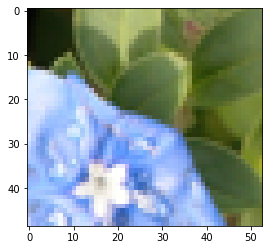

Input image (Up-scale factor 3): 


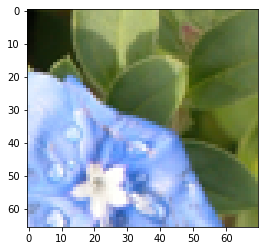

In [58]:
trainExample4 = SuperResolutionDataset("train_data/Set91", 4, testing=True)
print("Input image (Up-scale factor 4): ")
trainExample4.imshow_input(6)

trainExample3 = SuperResolutionDataset("train_data/Set91", 3, testing=True)
print("Input image (Up-scale factor 3): ")
trainExample3.imshow_input(6)

Target image: 


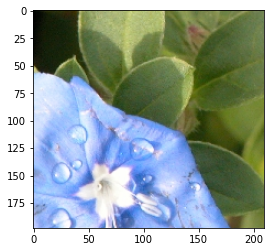

In [57]:
print("Target image: ")
trainExample3.imshow_target(6)

## Network Architecture

In [2]:
import torch.nn as nn
import torch

class SuperResolutionNet(nn.Module):
    def __init__(self, r, activation=nn.Identity()):
        super().__init__()
        self.r = r
        self.activation = activation

        self.deconvolution = nn.PixelShuffle(self.r)

        self.layers = nn.ModuleList([
            nn.Conv2d(3, 64, 5, padding=2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 32, 3, padding=1),
        ])

        self.last_layer = nn.Conv2d(32, self.r * self.r * 3, 3, padding=1)

        # self.params = list(self.layers.parameters())

        self.l = len(self.layers) - 1  # The number of hidden layers

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))

        x = self.last_layer(x)  # Don't use the activation on the last convolutional layer

        if not self.training:
          x = self.deconvolution(x)

        return x

## Training Network
Function to train a certain network with a certain data loader and hyperparameters

In [27]:
import os
import time
import math
import datetime

from torch import optim
from SuperResolutionNet import SuperResolutionNet

def mse_to_psnr(mse):
    return 10 * math.log10(1. / mse)

def train(net, use_gpu, train_loader, r,
          learning_rate=0.01,
          max_epochs_without_improvement=100,
          max_epochs=30000,
          print_output=True,
          momentum=0.9,
          learning_rate_factor=0.99,
          beta1=0.9,
          beta2=0.999):

    # Decide to use GPU or not.
    if use_gpu:
        net = net.cuda()
        if print_output:
          print('Running on gpu')

    # Set loss function and optimizer.
    loss_function = nn.MSELoss()

    optimizer = optim.Adam(
    [
        {"params": net.layers.parameters()},
        {"params": net.last_layer.parameters(), "lr": learning_rate/10},
    ],
    betas=(beta1, beta2),
    lr=learning_rate,
)

    # Save computer name to use when storing network
    computer_name = "unknown"
    try:
      computer_name = os.environ['COMPUTERNAME']
    except:
      pass

    # Initialize loss.
    lowest_loss = (0, float('inf'))
    previous_loss = float('inf')
    highest_psnr = - float('inf')

    begin_time = time.time()
    minimum_psnr_to_save = 20

    # Start training.
    mse_per_epoch = []
    for epoch in range(max_epochs):
        train_loss = []

        # Train and propagate through network.
        net.train()
        for input, target in train_loader:

            optimizer.zero_grad()

            output = net(input)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        mean_train_loss = np.mean(train_loss)
        mean_psnr = mse_to_psnr(mean_train_loss)

        if previous_loss - mean_train_loss < 0:
          old_learning_rate = optimizer.param_groups[0]['lr']
          optimizer.param_groups[0]['lr']
          new_learning_rate = max(0.0001, learning_rate_factor * old_learning_rate)
          optimizer.param_groups[0]['lr'] = new_learning_rate

          # Learning rate of the last layer should be 10 times lower
          optimizer.param_groups[1]['lr'] = new_learning_rate/10


        previous_loss = mean_train_loss
        mse_per_epoch.append(mean_train_loss)
          

        # Update the lowest loss if necessary.
        if mean_train_loss < lowest_loss[1]:
            #print(f"Epoch: {epoch: >3} Training Loss: {mean_train_loss:.6f} Mean PSNR: {mean_psnr:.2f} in {time.time() - begin_time:.2f}s #")
            lowest_loss = (epoch, mean_train_loss)
            highest_psnr = mean_psnr
          

            #If the psnr is above some threshold save this new best network.
            if highest_psnr > minimum_psnr_to_save:
                torch.save(net, f'SuperResulutionNet_best_of_run-{computer_name}')

        if epoch % 10 == 0 and print_output:
          
            print(
              f"Epoch: {epoch: >3} in {str(datetime.timedelta(seconds=int(time.time() - begin_time)))}, best epoch so far: Epoch: {lowest_loss[0]: >3} Training Loss: {lowest_loss[1]:.6f} Mean PSNR: {highest_psnr:.2f}, lr={ optimizer.param_groups[0]['lr']:.5f}")
            
            
            

        # If we didn't improve for some amount of epoch, lets stop.
        if epoch > lowest_loss[0] + max_epochs_without_improvement:
            if print_output:
                print(f"No improvement for the last {max_epochs_without_improvement} epochs, so stopping training...")
            break

    net.eval()
    if highest_psnr >= minimum_psnr_to_save:
        network_name = f'SuperResulutionNet_r-{r}_psnr-{int(round(highest_psnr * 100))}__mse-{int(round(lowest_loss[1] * 10000))}-{computer_name}'
        old_file = os.path.join(".", f'SuperResulutionNet_best_of_run-{computer_name}')
        new_file = os.path.join(".", network_name)
        if print_output:
            print(f'Saving best epoch ({lowest_loss[0]}) with loss: {lowest_loss[1]} and psnr: {highest_psnr} as:')
            print(network_name)

        os.rename(old_file, f"{new_file} - {time.time()}")
            
    elif print_output:
        print("Not high enough psnr to save the network...")

        
    plt.plot(mse_per_epoch)
    
    return lowest_loss[1]

Running the training algorithm

Running on gpu
Epoch:   0 in 0:00:00, best epoch so far: Epoch:   0 Training Loss: 0.092916 Mean PSNR: 10.32, lr=0.01000
Epoch:  10 in 0:00:06, best epoch so far: Epoch:   8 Training Loss: 0.010204 Mean PSNR: 19.91, lr=0.00970
Epoch:  20 in 0:00:12, best epoch so far: Epoch:  19 Training Loss: 0.003658 Mean PSNR: 24.37, lr=0.00932
Epoch:  30 in 0:00:18, best epoch so far: Epoch:  27 Training Loss: 0.002921 Mean PSNR: 25.34, lr=0.00886
Epoch:  40 in 0:00:24, best epoch so far: Epoch:  40 Training Loss: 0.002760 Mean PSNR: 25.59, lr=0.00860
Epoch:  50 in 0:00:30, best epoch so far: Epoch:  47 Training Loss: 0.002615 Mean PSNR: 25.82, lr=0.00826
Epoch:  60 in 0:00:35, best epoch so far: Epoch:  57 Training Loss: 0.002488 Mean PSNR: 26.04, lr=0.00786
Epoch:  70 in 0:00:41, best epoch so far: Epoch:  65 Training Loss: 0.002414 Mean PSNR: 26.17, lr=0.00732
Epoch:  80 in 0:00:46, best epoch so far: Epoch:  75 Training Loss: 0.002346 Mean PSNR: 26.30, lr=0.00703
Epoch:  90 in 0:00:52, best epo

Epoch: 780 in 0:07:31, best epoch so far: Epoch: 779 Training Loss: 0.001983 Mean PSNR: 27.03, lr=0.00020
Epoch: 790 in 0:07:37, best epoch so far: Epoch: 779 Training Loss: 0.001983 Mean PSNR: 27.03, lr=0.00019
Epoch: 800 in 0:07:44, best epoch so far: Epoch: 794 Training Loss: 0.001982 Mean PSNR: 27.03, lr=0.00018
Epoch: 810 in 0:07:50, best epoch so far: Epoch: 794 Training Loss: 0.001982 Mean PSNR: 27.03, lr=0.00017
Epoch: 820 in 0:07:55, best epoch so far: Epoch: 794 Training Loss: 0.001982 Mean PSNR: 27.03, lr=0.00016
Epoch: 830 in 0:08:01, best epoch so far: Epoch: 794 Training Loss: 0.001982 Mean PSNR: 27.03, lr=0.00016
Epoch: 840 in 0:08:06, best epoch so far: Epoch: 794 Training Loss: 0.001982 Mean PSNR: 27.03, lr=0.00015
Epoch: 850 in 0:08:12, best epoch so far: Epoch: 845 Training Loss: 0.001982 Mean PSNR: 27.03, lr=0.00014
Epoch: 860 in 0:08:17, best epoch so far: Epoch: 845 Training Loss: 0.001982 Mean PSNR: 27.03, lr=0.00013
Epoch: 870 in 0:08:22, best epoch so far: Epoc

0.0019753283237290676

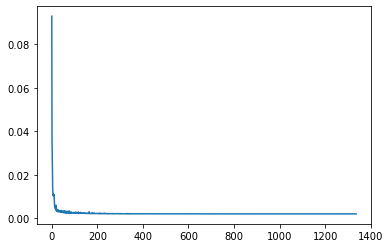

In [28]:
use_gpu = torch.cuda.is_available()

# Batch size.
bs = 16

# Upscale factor.
r = 3

# Load the training data.
training_set = SuperResolutionDataset("train_data/Set91", r, use_gpu=use_gpu)
train_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, shuffle=True)

# Initialize the network.
net = SuperResolutionNet(r, activation=nn.ReLU())

train(net, use_gpu, train_loader, r)

## Evaluation

In [4]:
import math

import PIL
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from os import listdir

# from SuperResolutionDataset import SuperResolutionDataset
import numpy as np


def imshow(img):
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def evaluate_by_name(network_name):
    net = torch.load(network_name)
    evaluate(net)

def mse_to_psnr(mse):
    return 10 * math.log10(1. / mse)
    
def evaluate(net):
    r = net.r
    print(f"r: {r}")
    net.eval()

    use_gpu = torch.cuda.is_available()

    test_set_paths = ["test_data/" + f for f in listdir("test_data")]
#     test_set_paths = ["test_data/Custom"]

    all_psnr = []
    for path in test_set_paths:
        psnr = []
        test_set = SuperResolutionDataset(path, r, use_gpu=use_gpu, testing=True)


        test_loader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)


        for input, target in iter(test_loader):
            if use_gpu:
                input = input.cuda()
                target = target.cuda()

            if input.size()[1] == 1:
                input = input.repeat(1, 3, 1, 1)

            output = net(input)


            if use_gpu:
                input = input.cpu()
                output = output.cpu()
                target = target.cpu()


            bicubic = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.BICUBIC),
                transforms.ToTensor()
            ])
            bicubic_upscaled = bicubic(input[0])

            nearest_neighbour = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.NEAREST),
                transforms.ToTensor()
            ])

            input = nearest_neighbour(input[0])
            # output = torch.clamp(output.detach(), 0, 1)

            if target.size()[1] == 1:
                target = target.repeat(1, 3, 1, 1)

            mse_loss = nn.MSELoss()(output, target).item()
            psnr.append(mse_to_psnr(mse_loss))

            images = [input, target[0], output.detach()[0], bicubic_upscaled]

        print(f"{path} - avarage psnr: {np.mean(psnr)}")
        all_psnr += psnr

    avarage_psnr = np.mean(all_psnr)
    print(f"Average: {avarage_psnr}")
    return avarage_psnr
    # plt.show()

In [0]:
evaluate(net)

r: 3
test_data/BSD500 - avarage psnr: 26.494012059518397, psnr of average mse: 25.2864189330735
test_data/Set5 - avarage psnr: 29.21752743513349, psnr of average mse: 27.90425606306598
test_data/BSD300 - avarage psnr: 26.609591910011968, psnr of average mse: 25.31428614449313
test_data/Set14 - avarage psnr: 26.28821186034873, psnr of average mse: 25.303261110726737
test_data/SuperTexture - avarage psnr: 24.472527774841037, psnr of average mse: 22.293787861574557


In [46]:
evaluate_by_name('SuperResulutionNet_r-3_psnr-2791__mse-16-JORIS-DESKTOP')

r: 3
test_data/BSD300 - avarage psnr: 27.05839365855887
test_data/BSD500 - avarage psnr: 26.96261909989194
test_data/Set14 - avarage psnr: 26.85847043276974
test_data/Set5 - avarage psnr: 30.32210170807329
test_data/SuperTexture - avarage psnr: 24.823162442721056
Average: 26.704090925992503


### Finding Hyperparameters
We use the AX framework to find the best hyperparameters for the network. We used it to find the learning rate, the learning rate update factor, and the beta values used by the Adam optimizer.

In [0]:
!pip3 install ax-platform 

In [14]:
from ax import optimize

# Trains a network and returns the lowest achieved MSE.
def train_evaluate(parameters):
    use_gpu = torch.cuda.is_available()
    bs = 64
    r = 3

    training_set = SuperResolutionDataset('train_data/Set91', r, use_gpu=use_gpu)
    # training_set = SuperResolutionDataset('test_data/BSD500', r, use_gpu=use_gpu)

    train_loader = torch.utils.data.DataLoader(
        training_set, batch_size=bs, shuffle=True, num_workers=0
    )

    # Initialize the network.
    net = SuperResolutionNet(r, activation=nn.ReLU())

    return train(net, use_gpu, train_loader, r,
                 learning_rate=parameters['lr'],
                 learning_rate_factor=parameters['learning_rate_factor'],
                 beta1=parameters['beta1'],
                 beta2=parameters['beta2'],
                 print_output=False)


# Runs the optimization algorithm on the given parameters.
best_parameters, best_values, experiment, model = optimize(
        parameters=[
            {"name": "lr", "type": "range", "bounds": [1e-6, 0.5], "log_scale": True},
            {"name": "beta1", "type": "range", "bounds": [0., 0.999]},
            {"name": "beta2", "type": "range", "bounds": [0., 0.999]},
            {"name": "learning_rate_factor", "type": "range", "bounds": [0.1, 1.]},
        ],
        total_trials=20,
        # Function to optimize
        evaluation_function=train_evaluate,
        objective_name='training-error',
        minimize=True,
    )

print(best_parameters, best_values, experiment, model)

[INFO 04-20 13:05:32] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 04-20 13:05:32] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 04-20 13:05:32] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 13:23:23] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-20 13:28:12] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-20 13:44:37] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-20 13:46:06] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 14:00:07] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 14:10:35] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 14:30:57] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 

{'lr': 7.756000475253536e-06, 'beta1': 0.5464540335576926, 'beta2': 0.28137519247576326, 'learning_rate_factor': 0.798803753367605} ({'training-error': 0.0018044673450546824}, {'training-error': {'training-error': 3.638674880974261e-11}}) SimpleExperiment(None) <ax.modelbridge.torch.TorchModelBridge object at 0x000001B6B093BF08>


In [15]:
from ax import Experiment, save

save(experiment, "experiment-batch-64.json")

In [47]:
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour


render(plot_contour(model=model, param_x='learning_rate_factor', param_y='lr', metric_name='training-error'))
render(plot_contour(model=model, param_x='beta1', param_y='beta2', metric_name='training-error'))

Use the best parameters found by the bayesion optimization to train a network.

In [25]:
use_gpu = torch.cuda.is_available()

r = 3
bs = 64
net = SuperResolutionNet(r, activation=nn.ReLU())

# Load the training data.
training_set = SuperResolutionDataset("train_data/Set91", r, use_gpu=use_gpu)
train_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, shuffle=True)

train(net, use_gpu, train_loader, r,
                 learning_rate=best_parameters['lr'],
                 learning_rate_factor=best_parameters['learning_rate_factor'],
                 beta1=best_parameters['beta1'],
                 beta2=best_parameters['beta2'],
                 )
evaluate(net)

Running on gpu
Epoch:   0 in 0:00:00, best epoch so far: Epoch:   0 Training Loss: 0.269971 Mean PSNR: 5.69, lr=0.00001
Epoch:  10 in 0:00:01, best epoch so far: Epoch:  10 Training Loss: 0.231381 Mean PSNR: 6.36, lr=0.00001
Epoch:  20 in 0:00:02, best epoch so far: Epoch:  20 Training Loss: 0.171780 Mean PSNR: 7.65, lr=0.00001
Epoch:  30 in 0:00:04, best epoch so far: Epoch:  30 Training Loss: 0.128801 Mean PSNR: 8.90, lr=0.00001
Epoch:  40 in 0:00:05, best epoch so far: Epoch:  40 Training Loss: 0.108846 Mean PSNR: 9.63, lr=0.00001
Epoch:  50 in 0:00:06, best epoch so far: Epoch:  50 Training Loss: 0.093733 Mean PSNR: 10.28, lr=0.00001
Epoch:  60 in 0:00:08, best epoch so far: Epoch:  60 Training Loss: 0.080342 Mean PSNR: 10.95, lr=0.00001
Epoch:  70 in 0:00:09, best epoch so far: Epoch:  70 Training Loss: 0.068730 Mean PSNR: 11.63, lr=0.00001
Epoch:  80 in 0:00:10, best epoch so far: Epoch:  80 Training Loss: 0.058820 Mean PSNR: 12.30, lr=0.00001
Epoch:  90 in 0:00:11, best epoch so

Epoch: 780 in 0:02:04, best epoch so far: Epoch: 780 Training Loss: 0.003112 Mean PSNR: 25.07, lr=0.00010
Epoch: 790 in 0:02:05, best epoch so far: Epoch: 790 Training Loss: 0.003089 Mean PSNR: 25.10, lr=0.00010
Epoch: 800 in 0:02:07, best epoch so far: Epoch: 796 Training Loss: 0.003066 Mean PSNR: 25.13, lr=0.00010
Epoch: 810 in 0:02:09, best epoch so far: Epoch: 810 Training Loss: 0.003044 Mean PSNR: 25.17, lr=0.00010
Epoch: 820 in 0:02:11, best epoch so far: Epoch: 820 Training Loss: 0.003021 Mean PSNR: 25.20, lr=0.00010
Epoch: 830 in 0:02:12, best epoch so far: Epoch: 827 Training Loss: 0.003007 Mean PSNR: 25.22, lr=0.00010
Epoch: 840 in 0:02:14, best epoch so far: Epoch: 837 Training Loss: 0.002992 Mean PSNR: 25.24, lr=0.00010
Epoch: 850 in 0:02:15, best epoch so far: Epoch: 846 Training Loss: 0.002974 Mean PSNR: 25.27, lr=0.00010
Epoch: 860 in 0:02:18, best epoch so far: Epoch: 860 Training Loss: 0.002953 Mean PSNR: 25.30, lr=0.00010
Epoch: 870 in 0:02:20, best epoch so far: Epoc

Epoch: 1550 in 0:04:07, best epoch so far: Epoch: 1549 Training Loss: 0.002454 Mean PSNR: 26.10, lr=0.00010
Epoch: 1560 in 0:04:09, best epoch so far: Epoch: 1560 Training Loss: 0.002451 Mean PSNR: 26.11, lr=0.00010
Epoch: 1570 in 0:04:10, best epoch so far: Epoch: 1569 Training Loss: 0.002448 Mean PSNR: 26.11, lr=0.00010
Epoch: 1580 in 0:04:12, best epoch so far: Epoch: 1580 Training Loss: 0.002446 Mean PSNR: 26.12, lr=0.00010
Epoch: 1590 in 0:04:14, best epoch so far: Epoch: 1589 Training Loss: 0.002441 Mean PSNR: 26.12, lr=0.00010
Epoch: 1600 in 0:04:16, best epoch so far: Epoch: 1596 Training Loss: 0.002439 Mean PSNR: 26.13, lr=0.00010
Epoch: 1610 in 0:04:18, best epoch so far: Epoch: 1596 Training Loss: 0.002439 Mean PSNR: 26.13, lr=0.00010
Epoch: 1620 in 0:04:20, best epoch so far: Epoch: 1619 Training Loss: 0.002432 Mean PSNR: 26.14, lr=0.00010
Epoch: 1630 in 0:04:21, best epoch so far: Epoch: 1625 Training Loss: 0.002429 Mean PSNR: 26.15, lr=0.00010
Epoch: 1640 in 0:04:23, best

Epoch: 2310 in 0:06:15, best epoch so far: Epoch: 2309 Training Loss: 0.002262 Mean PSNR: 26.45, lr=0.00010
Epoch: 2320 in 0:06:16, best epoch so far: Epoch: 2312 Training Loss: 0.002260 Mean PSNR: 26.46, lr=0.00010
Epoch: 2330 in 0:06:18, best epoch so far: Epoch: 2330 Training Loss: 0.002258 Mean PSNR: 26.46, lr=0.00010
Epoch: 2340 in 0:06:19, best epoch so far: Epoch: 2332 Training Loss: 0.002257 Mean PSNR: 26.46, lr=0.00010
Epoch: 2350 in 0:06:21, best epoch so far: Epoch: 2343 Training Loss: 0.002255 Mean PSNR: 26.47, lr=0.00010
Epoch: 2360 in 0:06:23, best epoch so far: Epoch: 2353 Training Loss: 0.002254 Mean PSNR: 26.47, lr=0.00010
Epoch: 2370 in 0:06:25, best epoch so far: Epoch: 2367 Training Loss: 0.002252 Mean PSNR: 26.47, lr=0.00010
Epoch: 2380 in 0:06:27, best epoch so far: Epoch: 2379 Training Loss: 0.002245 Mean PSNR: 26.49, lr=0.00010
Epoch: 2390 in 0:06:28, best epoch so far: Epoch: 2379 Training Loss: 0.002245 Mean PSNR: 26.49, lr=0.00010
Epoch: 2400 in 0:06:30, best

Epoch: 3070 in 0:08:25, best epoch so far: Epoch: 3068 Training Loss: 0.002129 Mean PSNR: 26.72, lr=0.00010
Epoch: 3080 in 0:08:26, best epoch so far: Epoch: 3080 Training Loss: 0.002126 Mean PSNR: 26.72, lr=0.00010
Epoch: 3090 in 0:08:28, best epoch so far: Epoch: 3080 Training Loss: 0.002126 Mean PSNR: 26.72, lr=0.00010
Epoch: 3100 in 0:08:30, best epoch so far: Epoch: 3095 Training Loss: 0.002125 Mean PSNR: 26.73, lr=0.00010
Epoch: 3110 in 0:08:31, best epoch so far: Epoch: 3110 Training Loss: 0.002122 Mean PSNR: 26.73, lr=0.00010
Epoch: 3120 in 0:08:33, best epoch so far: Epoch: 3110 Training Loss: 0.002122 Mean PSNR: 26.73, lr=0.00010
Epoch: 3130 in 0:08:34, best epoch so far: Epoch: 3130 Training Loss: 0.002120 Mean PSNR: 26.74, lr=0.00010
Epoch: 3140 in 0:08:36, best epoch so far: Epoch: 3130 Training Loss: 0.002120 Mean PSNR: 26.74, lr=0.00010
Epoch: 3150 in 0:08:38, best epoch so far: Epoch: 3149 Training Loss: 0.002118 Mean PSNR: 26.74, lr=0.00010
Epoch: 3160 in 0:08:40, best

Epoch: 3830 in 0:10:27, best epoch so far: Epoch: 3824 Training Loss: 0.002033 Mean PSNR: 26.92, lr=0.00010
Epoch: 3840 in 0:10:29, best epoch so far: Epoch: 3831 Training Loss: 0.002033 Mean PSNR: 26.92, lr=0.00010
Epoch: 3850 in 0:10:30, best epoch so far: Epoch: 3845 Training Loss: 0.002031 Mean PSNR: 26.92, lr=0.00010
Epoch: 3860 in 0:10:32, best epoch so far: Epoch: 3845 Training Loss: 0.002031 Mean PSNR: 26.92, lr=0.00010
Epoch: 3870 in 0:10:33, best epoch so far: Epoch: 3862 Training Loss: 0.002030 Mean PSNR: 26.92, lr=0.00010
Epoch: 3880 in 0:10:35, best epoch so far: Epoch: 3880 Training Loss: 0.002029 Mean PSNR: 26.93, lr=0.00010
Epoch: 3890 in 0:10:36, best epoch so far: Epoch: 3890 Training Loss: 0.002027 Mean PSNR: 26.93, lr=0.00010
Epoch: 3900 in 0:10:38, best epoch so far: Epoch: 3891 Training Loss: 0.002024 Mean PSNR: 26.94, lr=0.00010
Epoch: 3910 in 0:10:40, best epoch so far: Epoch: 3891 Training Loss: 0.002024 Mean PSNR: 26.94, lr=0.00010
Epoch: 3920 in 0:10:41, best

Epoch: 4590 in 0:12:34, best epoch so far: Epoch: 4573 Training Loss: 0.001972 Mean PSNR: 27.05, lr=0.00010
Epoch: 4600 in 0:12:36, best epoch so far: Epoch: 4594 Training Loss: 0.001972 Mean PSNR: 27.05, lr=0.00010
Epoch: 4610 in 0:12:37, best epoch so far: Epoch: 4609 Training Loss: 0.001970 Mean PSNR: 27.06, lr=0.00010
Epoch: 4620 in 0:12:39, best epoch so far: Epoch: 4609 Training Loss: 0.001970 Mean PSNR: 27.06, lr=0.00010
Epoch: 4630 in 0:12:40, best epoch so far: Epoch: 4626 Training Loss: 0.001968 Mean PSNR: 27.06, lr=0.00010
Epoch: 4640 in 0:12:42, best epoch so far: Epoch: 4638 Training Loss: 0.001968 Mean PSNR: 27.06, lr=0.00010
Epoch: 4650 in 0:12:43, best epoch so far: Epoch: 4649 Training Loss: 0.001967 Mean PSNR: 27.06, lr=0.00010
Epoch: 4660 in 0:12:45, best epoch so far: Epoch: 4649 Training Loss: 0.001967 Mean PSNR: 27.06, lr=0.00010
Epoch: 4670 in 0:12:46, best epoch so far: Epoch: 4649 Training Loss: 0.001967 Mean PSNR: 27.06, lr=0.00010
Epoch: 4680 in 0:12:48, best

Epoch: 5350 in 0:14:35, best epoch so far: Epoch: 5346 Training Loss: 0.001930 Mean PSNR: 27.14, lr=0.00010
Epoch: 5360 in 0:14:37, best epoch so far: Epoch: 5357 Training Loss: 0.001928 Mean PSNR: 27.15, lr=0.00010
Epoch: 5370 in 0:14:38, best epoch so far: Epoch: 5370 Training Loss: 0.001927 Mean PSNR: 27.15, lr=0.00010
Epoch: 5380 in 0:14:40, best epoch so far: Epoch: 5370 Training Loss: 0.001927 Mean PSNR: 27.15, lr=0.00010
Epoch: 5390 in 0:14:41, best epoch so far: Epoch: 5387 Training Loss: 0.001927 Mean PSNR: 27.15, lr=0.00010
Epoch: 5400 in 0:14:43, best epoch so far: Epoch: 5398 Training Loss: 0.001926 Mean PSNR: 27.15, lr=0.00010
Epoch: 5410 in 0:14:44, best epoch so far: Epoch: 5406 Training Loss: 0.001926 Mean PSNR: 27.15, lr=0.00010
Epoch: 5420 in 0:14:46, best epoch so far: Epoch: 5412 Training Loss: 0.001926 Mean PSNR: 27.15, lr=0.00010
Epoch: 5430 in 0:14:47, best epoch so far: Epoch: 5412 Training Loss: 0.001926 Mean PSNR: 27.15, lr=0.00010
Epoch: 5440 in 0:14:49, best

Epoch: 6110 in 0:16:34, best epoch so far: Epoch: 6057 Training Loss: 0.001896 Mean PSNR: 27.22, lr=0.00010
Epoch: 6120 in 0:16:35, best epoch so far: Epoch: 6114 Training Loss: 0.001896 Mean PSNR: 27.22, lr=0.00010
Epoch: 6130 in 0:16:37, best epoch so far: Epoch: 6124 Training Loss: 0.001896 Mean PSNR: 27.22, lr=0.00010
Epoch: 6140 in 0:16:38, best epoch so far: Epoch: 6132 Training Loss: 0.001895 Mean PSNR: 27.22, lr=0.00010
Epoch: 6150 in 0:16:40, best epoch so far: Epoch: 6149 Training Loss: 0.001895 Mean PSNR: 27.22, lr=0.00010
Epoch: 6160 in 0:16:41, best epoch so far: Epoch: 6149 Training Loss: 0.001895 Mean PSNR: 27.22, lr=0.00010
Epoch: 6170 in 0:16:43, best epoch so far: Epoch: 6149 Training Loss: 0.001895 Mean PSNR: 27.22, lr=0.00010
Epoch: 6180 in 0:16:44, best epoch so far: Epoch: 6172 Training Loss: 0.001894 Mean PSNR: 27.23, lr=0.00010
Epoch: 6190 in 0:16:46, best epoch so far: Epoch: 6183 Training Loss: 0.001893 Mean PSNR: 27.23, lr=0.00010
Epoch: 6200 in 0:16:47, best

Epoch: 6870 in 0:18:27, best epoch so far: Epoch: 6856 Training Loss: 0.001871 Mean PSNR: 27.28, lr=0.00010
Epoch: 6880 in 0:18:28, best epoch so far: Epoch: 6876 Training Loss: 0.001871 Mean PSNR: 27.28, lr=0.00010
Epoch: 6890 in 0:18:30, best epoch so far: Epoch: 6886 Training Loss: 0.001870 Mean PSNR: 27.28, lr=0.00010
Epoch: 6900 in 0:18:31, best epoch so far: Epoch: 6897 Training Loss: 0.001870 Mean PSNR: 27.28, lr=0.00010
Epoch: 6910 in 0:18:33, best epoch so far: Epoch: 6897 Training Loss: 0.001870 Mean PSNR: 27.28, lr=0.00010
Epoch: 6920 in 0:18:35, best epoch so far: Epoch: 6897 Training Loss: 0.001870 Mean PSNR: 27.28, lr=0.00010
Epoch: 6930 in 0:18:36, best epoch so far: Epoch: 6927 Training Loss: 0.001870 Mean PSNR: 27.28, lr=0.00010
Epoch: 6940 in 0:18:37, best epoch so far: Epoch: 6927 Training Loss: 0.001870 Mean PSNR: 27.28, lr=0.00010
Epoch: 6950 in 0:18:39, best epoch so far: Epoch: 6941 Training Loss: 0.001869 Mean PSNR: 27.28, lr=0.00010
Epoch: 6960 in 0:18:40, best

Epoch: 7630 in 0:20:19, best epoch so far: Epoch: 7610 Training Loss: 0.001852 Mean PSNR: 27.32, lr=0.00010
Epoch: 7640 in 0:20:20, best epoch so far: Epoch: 7610 Training Loss: 0.001852 Mean PSNR: 27.32, lr=0.00010
Epoch: 7650 in 0:20:22, best epoch so far: Epoch: 7642 Training Loss: 0.001851 Mean PSNR: 27.33, lr=0.00010
Epoch: 7660 in 0:20:23, best epoch so far: Epoch: 7642 Training Loss: 0.001851 Mean PSNR: 27.33, lr=0.00010
Epoch: 7670 in 0:20:25, best epoch so far: Epoch: 7642 Training Loss: 0.001851 Mean PSNR: 27.33, lr=0.00010
Epoch: 7680 in 0:20:26, best epoch so far: Epoch: 7671 Training Loss: 0.001850 Mean PSNR: 27.33, lr=0.00010
Epoch: 7690 in 0:20:28, best epoch so far: Epoch: 7671 Training Loss: 0.001850 Mean PSNR: 27.33, lr=0.00010
Epoch: 7700 in 0:20:29, best epoch so far: Epoch: 7671 Training Loss: 0.001850 Mean PSNR: 27.33, lr=0.00010
Epoch: 7710 in 0:20:31, best epoch so far: Epoch: 7671 Training Loss: 0.001850 Mean PSNR: 27.33, lr=0.00010
Epoch: 7720 in 0:20:32, best

Epoch: 8390 in 0:22:13, best epoch so far: Epoch: 8388 Training Loss: 0.001833 Mean PSNR: 27.37, lr=0.00010
Epoch: 8400 in 0:22:14, best epoch so far: Epoch: 8388 Training Loss: 0.001833 Mean PSNR: 27.37, lr=0.00010
Epoch: 8410 in 0:22:16, best epoch so far: Epoch: 8407 Training Loss: 0.001833 Mean PSNR: 27.37, lr=0.00010
Epoch: 8420 in 0:22:17, best epoch so far: Epoch: 8407 Training Loss: 0.001833 Mean PSNR: 27.37, lr=0.00010
Epoch: 8430 in 0:22:19, best epoch so far: Epoch: 8407 Training Loss: 0.001833 Mean PSNR: 27.37, lr=0.00010
Epoch: 8440 in 0:22:20, best epoch so far: Epoch: 8434 Training Loss: 0.001833 Mean PSNR: 27.37, lr=0.00010
Epoch: 8450 in 0:22:22, best epoch so far: Epoch: 8449 Training Loss: 0.001833 Mean PSNR: 27.37, lr=0.00010
Epoch: 8460 in 0:22:24, best epoch so far: Epoch: 8449 Training Loss: 0.001833 Mean PSNR: 27.37, lr=0.00010
Epoch: 8470 in 0:22:25, best epoch so far: Epoch: 8449 Training Loss: 0.001833 Mean PSNR: 27.37, lr=0.00010
Epoch: 8480 in 0:22:27, best

Epoch: 9150 in 0:24:19, best epoch so far: Epoch: 9147 Training Loss: 0.001818 Mean PSNR: 27.40, lr=0.00010
Epoch: 9160 in 0:24:21, best epoch so far: Epoch: 9147 Training Loss: 0.001818 Mean PSNR: 27.40, lr=0.00010
Epoch: 9170 in 0:24:22, best epoch so far: Epoch: 9147 Training Loss: 0.001818 Mean PSNR: 27.40, lr=0.00010
Epoch: 9180 in 0:24:23, best epoch so far: Epoch: 9147 Training Loss: 0.001818 Mean PSNR: 27.40, lr=0.00010
Epoch: 9190 in 0:24:25, best epoch so far: Epoch: 9189 Training Loss: 0.001818 Mean PSNR: 27.40, lr=0.00010
Epoch: 9200 in 0:24:26, best epoch so far: Epoch: 9193 Training Loss: 0.001818 Mean PSNR: 27.40, lr=0.00010
Epoch: 9210 in 0:24:28, best epoch so far: Epoch: 9193 Training Loss: 0.001818 Mean PSNR: 27.40, lr=0.00010
Epoch: 9220 in 0:24:30, best epoch so far: Epoch: 9193 Training Loss: 0.001818 Mean PSNR: 27.40, lr=0.00010
Epoch: 9230 in 0:24:31, best epoch so far: Epoch: 9193 Training Loss: 0.001818 Mean PSNR: 27.40, lr=0.00010
Epoch: 9240 in 0:24:33, best

Epoch: 9910 in 0:26:18, best epoch so far: Epoch: 9908 Training Loss: 0.001804 Mean PSNR: 27.44, lr=0.00010
Epoch: 9920 in 0:26:19, best epoch so far: Epoch: 9908 Training Loss: 0.001804 Mean PSNR: 27.44, lr=0.00010
Epoch: 9930 in 0:26:21, best epoch so far: Epoch: 9908 Training Loss: 0.001804 Mean PSNR: 27.44, lr=0.00010
Epoch: 9940 in 0:26:22, best epoch so far: Epoch: 9908 Training Loss: 0.001804 Mean PSNR: 27.44, lr=0.00010
Epoch: 9950 in 0:26:24, best epoch so far: Epoch: 9942 Training Loss: 0.001804 Mean PSNR: 27.44, lr=0.00010
Epoch: 9960 in 0:26:25, best epoch so far: Epoch: 9942 Training Loss: 0.001804 Mean PSNR: 27.44, lr=0.00010
Epoch: 9970 in 0:26:27, best epoch so far: Epoch: 9942 Training Loss: 0.001804 Mean PSNR: 27.44, lr=0.00010
Epoch: 9980 in 0:26:29, best epoch so far: Epoch: 9942 Training Loss: 0.001804 Mean PSNR: 27.44, lr=0.00010
Epoch: 9990 in 0:26:30, best epoch so far: Epoch: 9942 Training Loss: 0.001804 Mean PSNR: 27.44, lr=0.00010
Epoch: 10000 in 0:26:31, bes

26.73870353631899

Using the best found network we show the performance on the images of the Set14 test set.

Input:


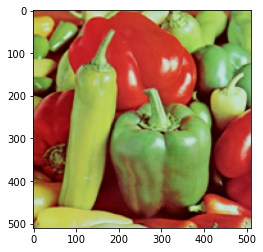

Target Image:


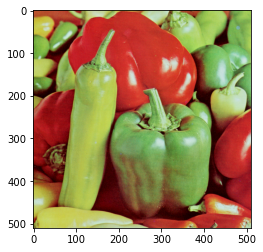

Our output Image:


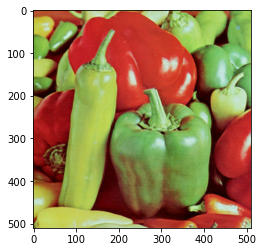

Bicubic upscaled Image:


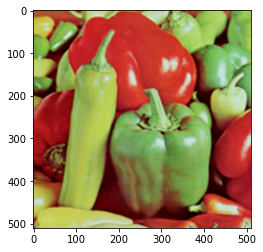

Input:


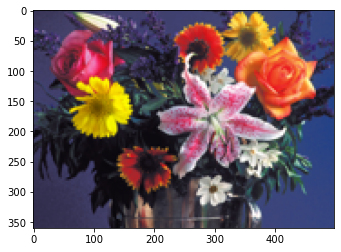

Target Image:


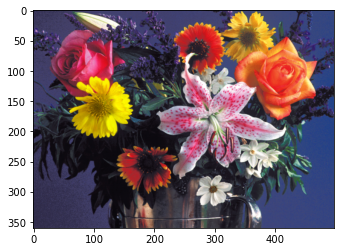

Our output Image:


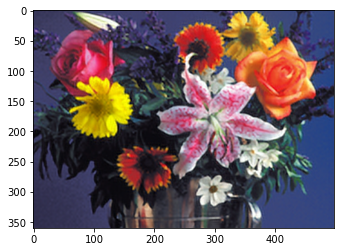

Bicubic upscaled Image:


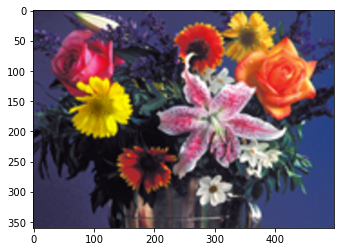

Input:


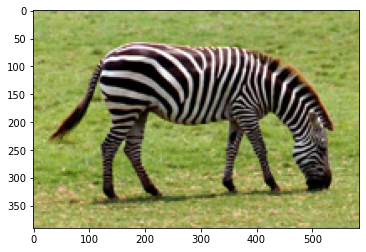

Target Image:


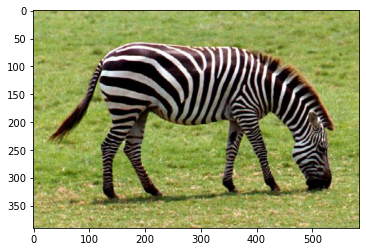

Our output Image:


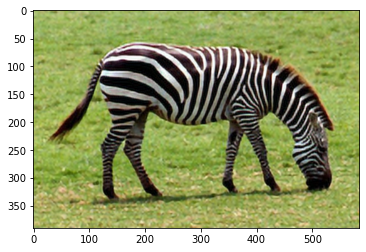

Bicubic upscaled Image:


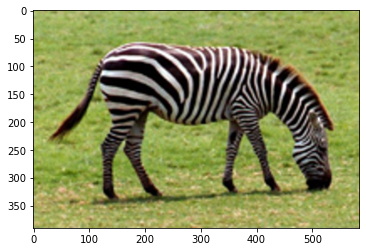

Input:


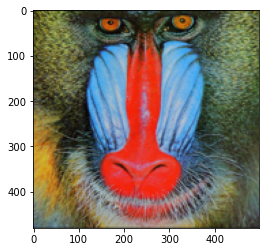

Target Image:


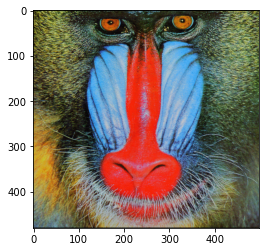

Our output Image:


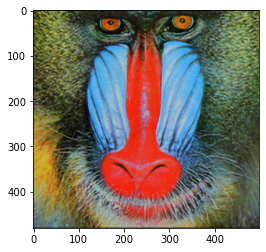

Bicubic upscaled Image:


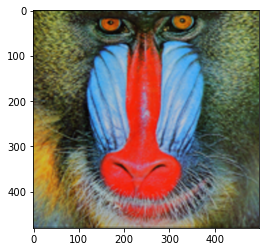

Input:


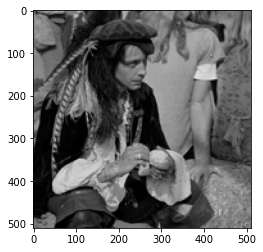

Target Image:


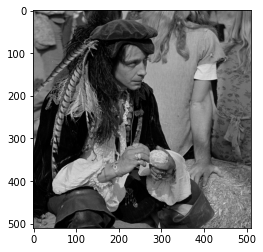

Our output Image:


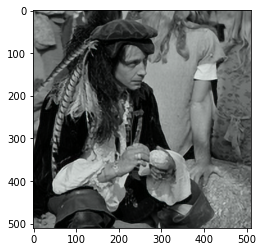

Bicubic upscaled Image:


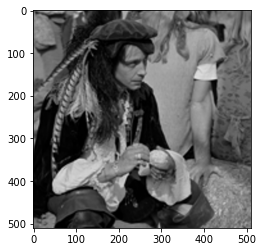

Input:


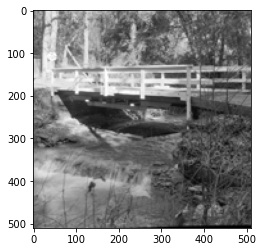

Target Image:


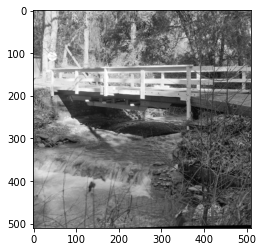

Our output Image:


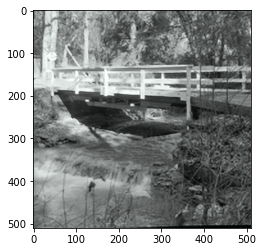

Bicubic upscaled Image:


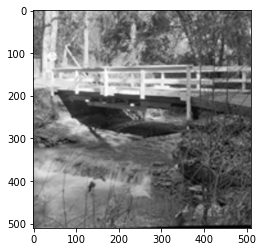

Input:


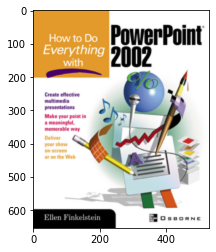

Target Image:


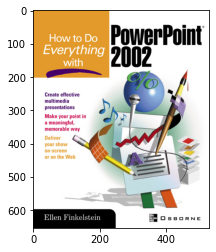

Our output Image:


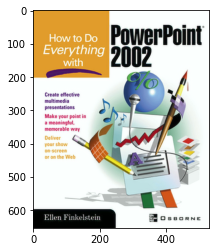

Bicubic upscaled Image:


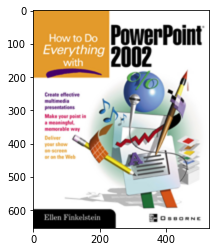

Input:


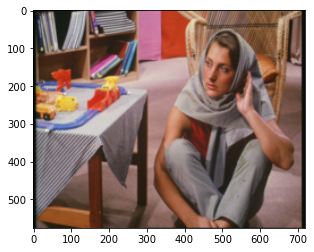

Target Image:


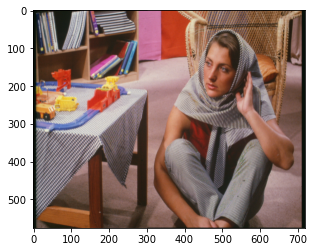

Our output Image:


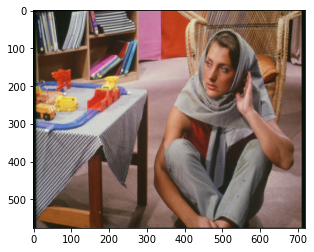

Bicubic upscaled Image:


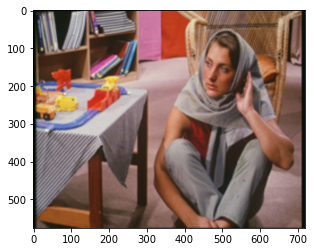

Input:


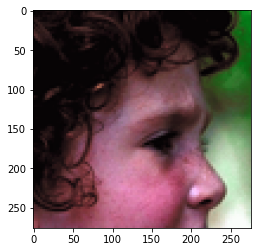

Target Image:


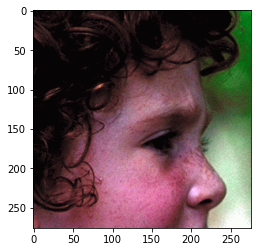

Our output Image:


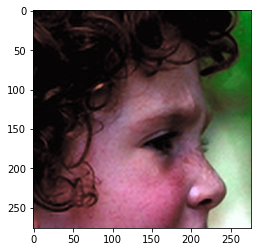

Bicubic upscaled Image:


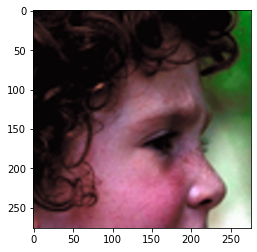

Input:


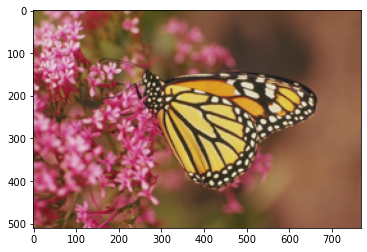

Target Image:


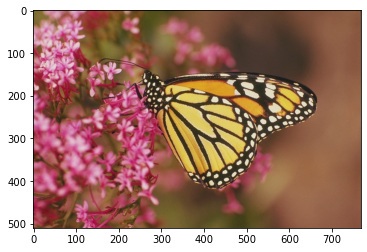

Our output Image:


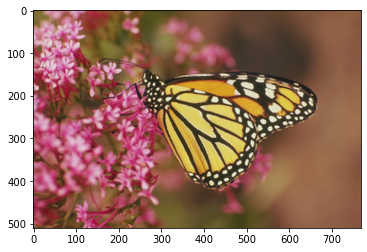

Bicubic upscaled Image:


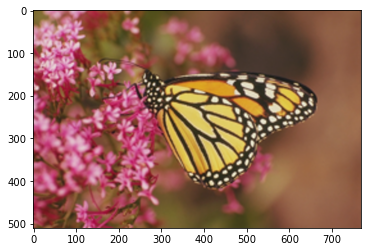

Input:


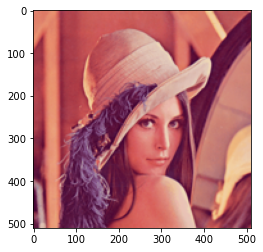

Target Image:


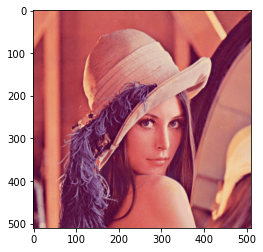

Our output Image:


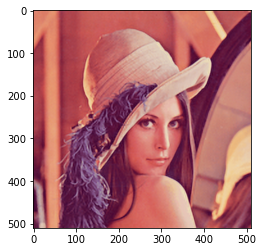

Bicubic upscaled Image:


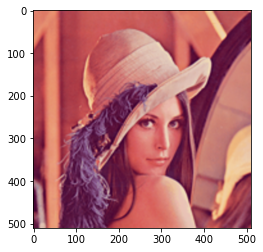

Input:


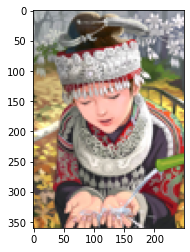

Target Image:


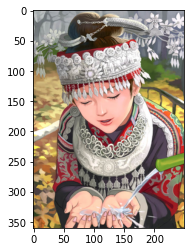

Our output Image:


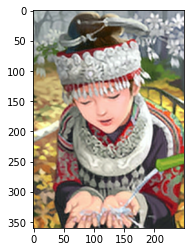

Bicubic upscaled Image:


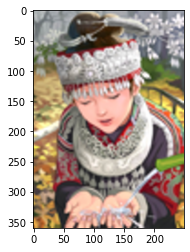

Input:


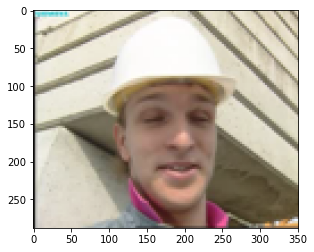

Target Image:


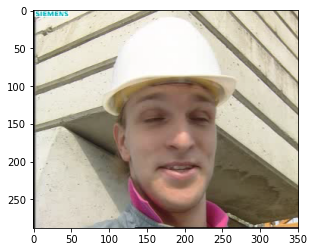

Our output Image:


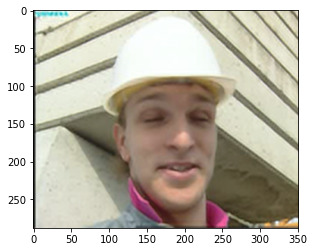

Bicubic upscaled Image:


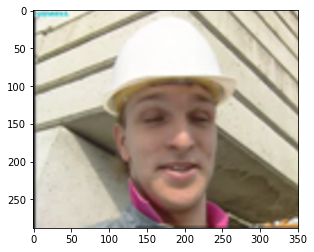

Input:


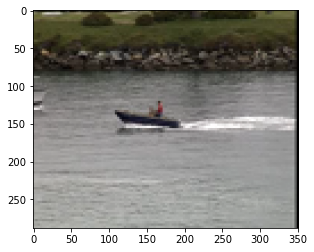

Target Image:


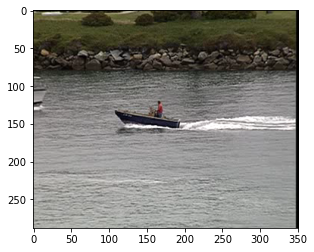

Our output Image:


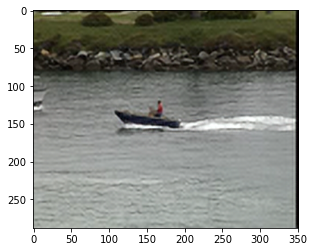

Bicubic upscaled Image:


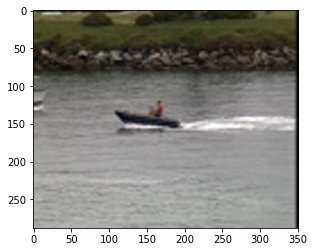

In [45]:
net = torch.load('SuperResulutionNet_r-3_psnr-2745__mse-18-BestFound')
net = net.cpu()
net.eval()

test_set = SuperResolutionDataset('test_data/Set14', r, use_gpu=False, testing=True)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=0)


for input, target in test_loader:
    if input.size()[1] == 1:
        input = input.repeat(1, 3, 1, 1)
    
    output = net(input)

    bicubic = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([int(r * input.size()[2]),
                           int(r * input.size()[3])],
                          PIL.Image.BICUBIC),
        transforms.ToTensor()
    ])
    bicubic_upscaled = bicubic(input[0])

    nearest_neighbour = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([int(r * input.size()[2]),
                           int(r * input.size()[3])],
                          PIL.Image.NEAREST),
        transforms.ToTensor()
    ])

    input = nearest_neighbour(input[0])
    output = torch.clamp(output.detach(), 0, 1)
    
    if target.size()[1] == 1:
        target = target.repeat(1, 3, 1, 1)

    images = [target[0], output.detach()[0], bicubic_upscaled]
    print("Input:")
    imshow(input)
    print("Target Image:")
    imshow(images[0])
    print("Our output Image:")
    imshow(images[1])
    print("Bicubic upscaled Image:")
    imshow(images[2])